## Karplus-Strong Algorithm to generate notes

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

We set the sampling frequency which will later be used to play audio.

In [3]:
Fs = 16000 # 16 KHz sampling rate

The above sampling frequency means that, there would be 16000 samples of data per second.

In Karplus-Strong (K-S) Algorithm, the period of the output signal is the length of the input finite signal. Say, if we have 50 samples in the input signal, then frequecy will be $$f = F_s / M$$, i.e, 16000/50, which would be $$320 Hz$$. 

Now let us choose an input signal with random values.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


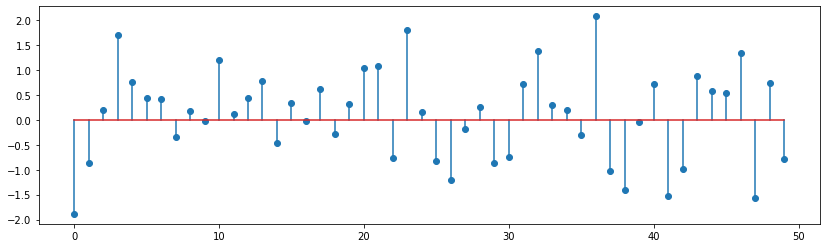

In [4]:
x_n = np.random.randn(50)
plt.stem(x_n);

Now let us define a function which returns output signal generated using K-S algorithm. Here we define the total number of output data points, as in theory, K-S algorithm generates infinite signal.

In [5]:
def KS(x, N, alpha=1):
    M = len(x)
    y = np.zeros(N)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if (n - M) >= 0 else 0)
    return y

In [6]:
y = KS(x_n, Fs * 2)  # Fs * 2 will generate two seconds worth of data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


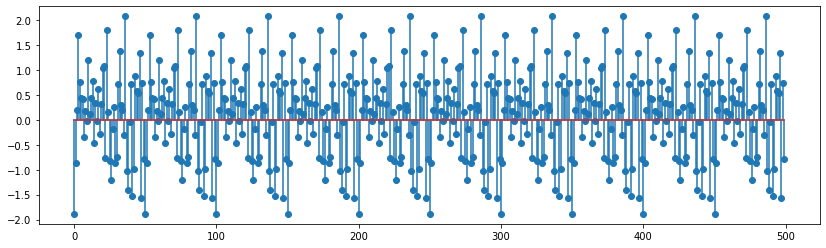

In [7]:
plt.stem(y[0:500]);  # Cause plotting the whole sequence would hang my device and plot would look clumsy

In [8]:
IPython.display.Audio(y, rate=Fs)

Now let us generate the output signal with some dampening effect. Let us provide $$\alpha = 0.99$.

In [9]:
y = KS(x_n, Fs * 2, alpha=0.99)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


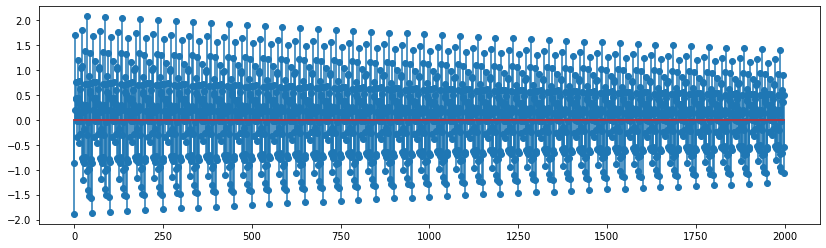

In [10]:
plt.stem(y[0:2000]);

One can observe the dampening amplitude above.

In [11]:
IPython.display.Audio(y, rate=Fs)

Now, we observe that everytime the initial buffer goes through the loop, it gets multiplied by $\alpha$. So we can rewrite the equation as
$$
  y[n] = \alpha^{\lfloor n/M \rfloor} x [n\mod M]
$$
Here, clearly the decay is dependent on $\alpha$ and $M$.
And this would cause the higher pitched notes to decay faster. So let first see that:

In [12]:
y1 = KS(np.random.randn(50), Fs * 2, alpha=0.99)
IPython.display.Audio(y1, rate=Fs)

In [13]:
y2 = KS(np.random.randn(10), Fs * 2, alpha=0.99)
IPython.display.Audio(y2, rate=Fs)

Here, $y2$ is a higher pitched note as the frequency $f = F_s / 10$ is higher than that of $y1$ which is $f = F_s / 50$. And we observe the decay is quite fast in $y2$. As, this is not good, let us compensate for this by changing $\alpha$. We shall adjust alpha so that all the notes have a decay comparable to that of buffer length of 50. This way the decay timing would match for all the signals.

In [14]:
def KS(x, N, alpha = 0.99):
    REF_LEN = 50
    M = len(x)
    a = alpha ** (float(M) / REF_LEN)
    y = np.zeros(N)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + a * (y[n-M] if n-M >= 0 else 0)
    return y

In [15]:
IPython.display.Audio(KS(np.random.rand(50), Fs * 2), rate=Fs)

In [16]:
IPython.display.Audio(KS(np.random.rand(10), Fs * 2), rate=Fs)

In [17]:
IPython.display.Audio(KS(np.random.rand(100), Fs * 2), rate=Fs)